In [305]:
#Lstm mdel for hate speech classification

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
 
# Text Pre-processing libraries
import nltk
import string
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#from wordcloud import WordCloud
 
# Tensorflow imports to build the model.
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nandinitengli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/nandinitengli/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nandinitengli/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [306]:
#read the file with the labels and the metadata
ids = pd.read_csv('hate-speech-dataset/annotations_metadata.csv')[["file_id", "subforum_id","num_contexts", "label"]]
ids.head()

,file_id,subforum_id,num_contexts,label
0,12834217_1,1346,0,noHate
1,12834217_2,1346,0,noHate
2,12834217_3,1346,0,noHate
3,12834217_4,1346,0,hate
4,12834217_5,1346,0,noHate


In [307]:
def get_data(paths):
  
    sets = []
    for p in paths:

        with open(p) as f:
            file_id = p.split('/')[-1].split('.')[0]
            sets.append((file_id, f.read()))

    return pd.DataFrame(sets, columns=["file_id", "text"])




In [308]:
import glob
df = get_data(glob.glob('./hate-speech-dataset/all_files/*.txt'))

df.head()

,file_id,text
0,13458115_2,It 's like that at most public boards .
1,13367480_1,I wonder if one of the victims opened the door...
2,30422449_1,Some people believe the Jack O ' Lantern also ...
3,14651837_4,Ready .... GO !!!
4,30527903_3,Thanks !


In [309]:
data = df.join(ids.set_index('file_id'), on='file_id')

data.head()

,file_id,text,subforum_id,num_contexts,label
0,13458115_2,It 's like that at most public boards .,1347,0,noHate
1,13367480_1,I wonder if one of the victims opened the door...,1345,0,noHate
2,30422449_1,Some people believe the Jack O ' Lantern also ...,1348,0,noHate
3,14651837_4,Ready .... GO !!!,1371,0,noHate
4,30527903_3,Thanks !,1359,0,noHate


In [331]:
data = data[data.label != 'relation']
data =  data[data.label != 'idk/skip']

In [311]:
X = data.iloc[:, [1,2,3]]
y = data['label']

In [312]:
X.head()

,text,subforum_id,num_contexts
0,It 's like that at most public boards .,1347,0
1,I wonder if one of the victims opened the door...,1345,0
2,Some people believe the Jack O ' Lantern also ...,1348,0
3,Ready .... GO !!!,1371,0
4,Thanks !,1359,0


In [313]:

# Removing punctuations present in the text
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)
 
X['text']= df['text'].apply(lambda x: remove_punctuations(x))
X.head()

,text,subforum_id,num_contexts
0,It s like that at most public boards,1347,0
1,I wonder if one of the victims opened the door...,1345,0
2,Some people believe the Jack O Lantern also r...,1348,0
3,Ready GO,1371,0
4,Thanks,1359,0


In [314]:
#Remove stop words from the text 
#notice, words like is, s and that at etc are removed
def remove_stopwords(text):
    stop_words = stopwords.words('english')
 
    imp_words = []
 
    # Storing the important words
    for word in str(text).split():
 
        if word not in stop_words:
 
            # Let's Lemmatize the word as well
            # before appending to the imp_words list.
 
            lemmatizer = WordNetLemmatizer()
            lemmatizer.lemmatize(word)
 
            imp_words.append(word)
 
    output = " ".join(imp_words)
 
    return output

X['text'] = X['text'].apply(lambda text: remove_stopwords(text))
X.head()

,text,subforum_id,num_contexts
0,It like public boards,1347,0
1,I wonder one victims opened door apartment reason,1345,0
2,Some people believe Jack O Lantern also repres...,1348,0
3,Ready GO,1371,0
4,Thanks,1359,0


In [315]:
#make all text lower case
X['text'] = X['text'].str.lower()
X.head()

,text,subforum_id,num_contexts
0,it like public boards,1347,0
1,i wonder one victims opened door apartment reason,1345,0
2,some people believe jack o lantern also repres...,1348,0
3,ready go,1371,0
4,thanks,1359,0


In [316]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

<AxesSubplot: xlabel='hate,noHate'>

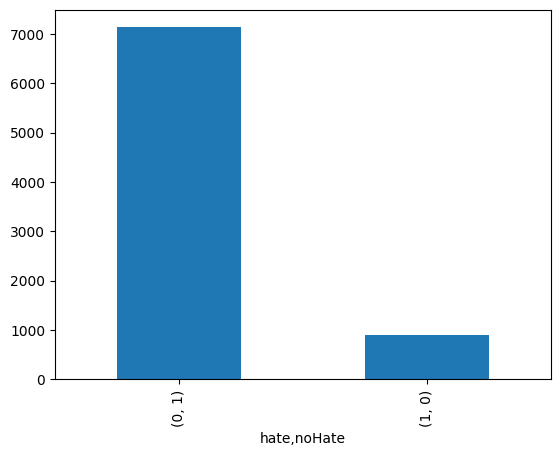

In [332]:
y_train.value_counts().plot(kind='bar')

<AxesSubplot: xlabel='hate,noHate'>

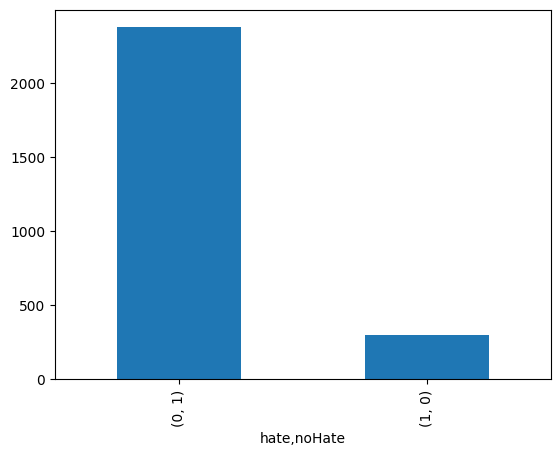

In [333]:
y_test.value_counts().plot(kind='bar')

In [319]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)


In [320]:
#vocab for hate sentences is 4,148 and for non-hate sentences is 13,154
max_words = 10000

#max len of hate sentences is 20.9 + 9, for no-hate it is 15 + 9 
max_len = 30
 
token = Tokenizer(num_words=max_words,
                  lower=True,
                  split=' ')
 
token.fit_on_texts(X_train['text'])

In [321]:
#Generating token embeddings
Training_seq = token.texts_to_sequences(X_train['text'])
Training_pad = pad_sequences(Training_seq,
                             maxlen=30,
                             padding='post',
                             truncating='post')
 
Testing_seq = token.texts_to_sequences(X_test['text'])
Testing_pad = pad_sequences(Testing_seq,
                            maxlen=30,
                            padding='post',
                            truncating='post')

In [322]:
Training_pad

array([[1044,    0,    0, ...,    0,    0,    0],
       [ 634, 1467, 4041, ...,    0,    0,    0],
       [ 635,   35,   93, ...,    0,    0,    0],
       ...,
       [  31,  119,    0, ...,    0,    0,    0],
       [1098, 2079,  210, ...,    0,    0,    0],
       [ 303,    8, 1599, ...,    0,    0,    0]], dtype=int32)

In [323]:
model = keras.models.Sequential([
    layers.Embedding(max_words, 32, input_length=max_len),
    layers.Bidirectional(layers.LSTM(16)),
    layers.Dense(512, activation='relu', kernel_regularizer='l1'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')
])
 
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 30, 32)            320000    
                                                                 
 bidirectional_11 (Bidirecti  (None, 32)               6272      
 onal)                                                           
                                                                 
 dense_22 (Dense)            (None, 512)               16896     
                                                                 
 batch_normalization_11 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                                 
 dense_23 (Dense)            (None, 2)               

In [324]:
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations=True
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [328]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
es = EarlyStopping(patience=5,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)
 
lr = ReduceLROnPlateau(patience = 5,
                       monitor = 'val_loss',
                       factor = 0.2,
                       verbose = 0)

In [329]:
history = model.fit(Training_pad, y_train.values,
                    validation_data=(Testing_pad,  y_test.values),
                    epochs=50,
                    verbose=1,
                    batch_size=30,
                    callbacks=[lr, es])

Epoch 1/50
268/268 [==============================] - 2s 6ms/step - loss: 0.0744 - accuracy: 0.9842 - val_loss: 0.5126 - val_accuracy: 0.8883 - lr: 2.0000e-04
Epoch 2/50
268/268 [==============================] - 2s 6ms/step - loss: 0.0574 - accuracy: 0.9874 - val_loss: 0.4994 - val_accuracy: 0.8819 - lr: 2.0000e-04
Epoch 3/50
268/268 [==============================] - 2s 6ms/step - loss: 0.0468 - accuracy: 0.9923 - val_loss: 0.5385 - val_accuracy: 0.8845 - lr: 2.0000e-04
Epoch 4/50
268/268 [==============================] - 2s 6ms/step - loss: 0.0407 - accuracy: 0.9930 - val_loss: 0.5638 - val_accuracy: 0.8744 - lr: 2.0000e-04
Epoch 5/50
268/268 [==============================] - 2s 6ms/step - loss: 0.0339 - accuracy: 0.9960 - val_loss: 0.5857 - val_accuracy: 0.8827 - lr: 2.0000e-04
Epoch 6/50
268/268 [==============================] - 2s 6ms/step - loss: 0.0329 - accuracy: 0.9958 - val_loss: 0.5533 - val_accuracy: 0.8789 - lr: 2.0000e-04


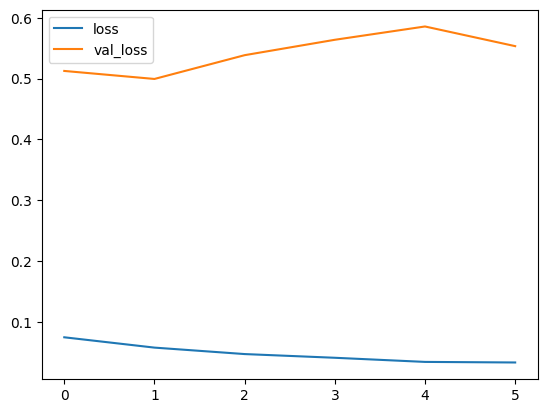

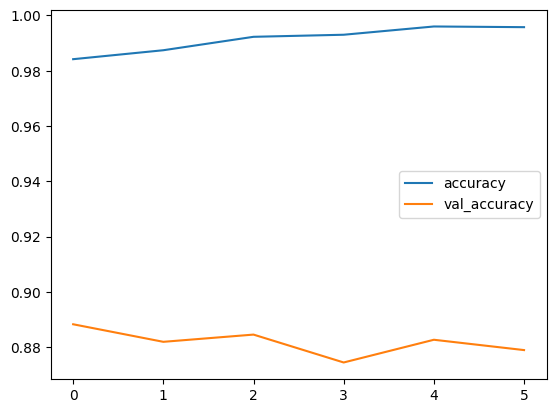

In [330]:

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()